In [119]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import pinot
import torch
from matplotlib import pyplot as plt
import numpy as np
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
ds = pinot.data.esol()

ds = pinot.data.utils.batch(ds, len(ds))

g_all, y_all = ds[0]



In [144]:
y_all.max()

tensor(1.5800)

In [168]:
xss = []

for _ in range(10):
    
    net = pinot.Net(
        representation=pinot.representation.Sequential(
            layer=pinot.representation.dgl_legacy.gn(),
            config=[32, 'tanh', 32, 'tanh', 32, 'tanh']),
            output_regressor=pinot.regressors.ExactGaussianProcessRegressor)

    optimizer = torch.optim.Adam(net.parameters(), 1e-3)

    acquisition = pinot.active.acquisition.upper_confidence_bound

    bo = pinot.active.experiment.BayesOptExperiment(
        net=net,
        acquisition=acquisition,
        q=96,
        optimizer=optimizer,
        data=ds[0],
        slice_fn=pinot.active.experiment._slice_fn_tuple, # pinot.active.
        collate_fn=pinot.active.experiment._collate_fn_graph, # pinot.active.
        n_epochs=10,
        )
    
    xs = []
    
    num_rounds = 4

    idx = 0
    bo.blind_pick(seed=None)
    bo.update_data()

    while idx < num_rounds:
        bo.train()
        bo.acquire()
        bo.update_data()


        x = pinot.active.acquisition.upper_confidence_bound(
            pinot.metrics._independent(bo.net.condition(g_all)),
            y_best=bo.y_best).max().detach().numpy() - bo.y_best.detach().numpy()

        
        xs.append(x)
        

        idx += 1
        
    print('---')
        
    xss.append(xs)



---
---
---
---
---
---
---
---
---
---


In [169]:
xss = np.array(xss)

In [170]:
xss

array([[0.38979506, 0.33585453, 0.33756232, 0.27545714],
       [0.38979506, 0.3976822 , 0.30348897, 0.27944005],
       [0.38979506, 0.44934404, 0.26747298, 0.29766953],
       [2.3797848 , 0.33685005, 0.30003405, 0.25857532],
       [2.379795  , 0.38961244, 0.29173505, 0.26116216],
       [0.38979506, 0.51642025, 0.31376445, 0.25202143],
       [0.39979506, 0.24476182, 0.5126146 , 0.2662903 ],
       [0.38979387, 0.28320897, 0.26345003, 0.2707727 ],
       [0.38979495, 0.55762994, 0.3053099 , 0.27630532],
       [0.38020575, 0.38831365, 0.43915117, 0.28022468]], dtype=float32)

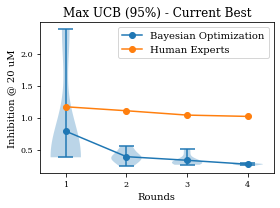

In [174]:
plt.rc('font', family='serif', size=10)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig, ax = plt.subplots(figsize=(4, 3))

cmap=plt.get_cmap('tab10')


ax.violinplot(
    xss)

ax.plot(
    [1, 2, 3, 4],
    xss.mean(axis=0),
    label='Bayesian Optimization',
    color=cmap(0),
    marker='o')

ax.plot(
    [1, 2, 3, 4],
    [
1.1689508,
1.1069205,
1.0391164,
1.0186026

    ],

marker='o',
    
label='Human Experts'
    
)

ax.legend()

ax.set_xticks([1, 2, 3, 4])
# ax.set_yticks([0.0, 0.5])

ax.set_xlabel('Rounds')
ax.set_title(r'Max UCB (95%) - Current Best')
ax.set_ylabel('Inhibition @ 20 uM')

# ax.set_ylabel('Probability of Improvement')

plt.tight_layout()
# plt.gcf().subplots_adjust(bottom=0.15)
fig.savefig('us_vs_human_ucb_diff.png', dpi=500)

0.05912459
0.2705282
0.26412833
0.24681127
0.28389525
0.21831346
0.16753924
0.16562176
0.17542863
0.20233583
0.17321217
0.19043827
0.20384932
0.23053497
0.26623857
0.24775815
0.2519226
0.25187832
0.24421704
0.27834392
0.22431964
0.24099278
0.27966988
0.26060325
0.27907306
0.26583457
0.28516787
0.24689454
0.25532883
0.2604534
0.2860607
0.25565195
---
0.76983404
0.38245052
0.010857105
0.08033496
0.16609263
0.22307193
0.26232588
0.19075608
0.25228333
0.18164212
0.15783507
0.18993813
0.18892658
0.20135272
0.18612874
0.2121849
0.21381825
0.23609829
0.27226806
0.23749077
0.22973609
0.27068037
0.22739577
0.2579043
0.30193788
0.271675
0.28153503
0.28644568
0.2655936
0.30183595
0.26870233
0.27616394
---
0.5396297
0.5394268
0.04450476
0.2927267
0.22560322
0.23601353
0.23286772
0.22495222
0.28612387
0.28894067
0.24549466
0.20834732
0.18596995
0.178927
0.2583332
0.2390697
0.24722171
0.22433788
0.22183692
0.22184265
0.25501007
0.2867635
0.28566563
0.27637208
0.23075628
0.25984395
0.27388704
0.27434

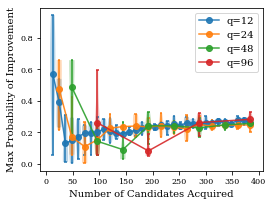

In [163]:
plt.rc('font', family='serif', size=10)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig, ax = plt.subplots(figsize=(4, 3))

cmap=plt.get_cmap('tab10')



for q_idx, q in enumerate([12, 24, 48, 96]):
    xss = []
    
    num_rounds = int(96 * 4 / q)

    for _ in range(5):

        net = pinot.Net(
            representation=pinot.representation.Sequential(
                layer=pinot.representation.dgl_legacy.gn(),
                config=[32, 'tanh', 32, 'tanh', 32, 'tanh']),
                output_regressor=pinot.regressors.ExactGaussianProcessRegressor)

        optimizer = torch.optim.Adam(net.parameters(), 1e-3)

        acquisition = pinot.active.acquisition.probability_of_improvement

        bo = pinot.active.experiment.BayesOptExperiment(
            net=net,
            acquisition=acquisition,
            q=q,
            optimizer=optimizer,
            data=ds[0],
            slice_fn=pinot.active.experiment._slice_fn_tuple, # pinot.active.
            collate_fn=pinot.active.experiment._collate_fn_graph, # pinot.active.
            n_epochs=10,
            )

        xs = []

        idx = 0
        bo.blind_pick(seed=None)
        bo.update_data()

        while idx < num_rounds:
            bo.train()
            bo.acquire()
            bo.update_data()


            x = pinot.active.acquisition.probability_of_improvement(
                pinot.metrics._independent(bo.net.condition(g_all)),
                y_best=bo.y_best).max().detach().numpy()

            print(x)

            xs.append(x)


            idx += 1

        print('---')

        xss.append(xs)


    xss = np.array(xss)
        
    ax.violinplot(
        dataset=xss,
        positions=[q * (idx_+1) for idx_ in range(num_rounds)],
        widths=10)

    ax.plot(
        [q * (idx_+1) for idx_ in range(num_rounds)],
        xss.mean(axis=0),
        label='q=%s' % q,
        color=cmap(q_idx),
        marker='o',
        alpha=0.9)
    
    ax.legend()
    

plt.xlabel('Number of Candidates Acquired')
plt.ylabel('Max Probability of Improvement')

plt.savefig('batch_size.png', dpi=500)


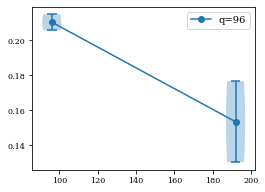

In [159]:

fig, ax = plt.subplots(figsize=(4, 3))
xss = np.array(xss)

ax.violinplot(
    dataset=xss,
    positions=[q * (idx_+1) for idx_ in range(num_rounds)],
    widths=10)

ax.plot(
    [q * (idx_+1) for idx_ in range(num_rounds)],
    xss.mean(axis=0),
    label='q=%s' % q,
    color=cmap(0),
    marker='o')

ax.legend()

In [153]:
xss

array([[0.2148804 , 0.13029253],
       [0.20567   , 0.17669177]], dtype=float32)